In [ ]:
# Fonctions importantes :
# clean_positions : Nettoie les positions des -1
# detect_frequency_switch : repérer les changements de fréquence.
# Charger les séquences pour chaque bloc.

# 1 : Nettoyer les positions au complet. Puis les rediviser pour chaque bloc.
# 1a : pour rediviser, faire un vecteur [1, 0, ..., 0] de longueur égale au nombre de positions, np.diff puis np.where(diff == -1)[0] + 1 pour les indices 
# 2 : Pour chaque bloc : repérer les changements de fréquence et l'associer à chaque trigger de son.
# 3 : Ceci fait, prendre toutes les positions et remplir entre les deux bornes.


In [4]:
import numpy as np
import os
from glob import glob
import re
import Experience.get_data as gd
from Experience.get_good_sessions import get_good_sessions
from Experience.Mapping import Mapping
import matplotlib.pyplot as plt

1000


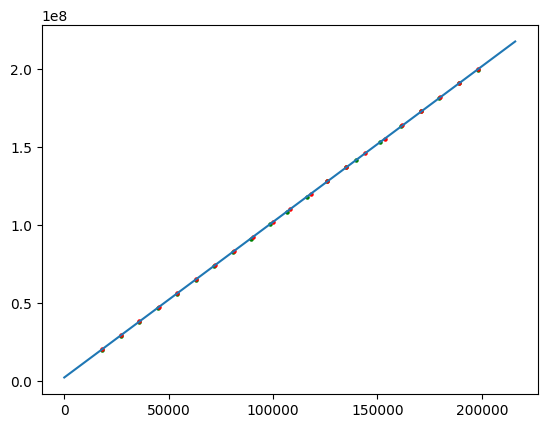

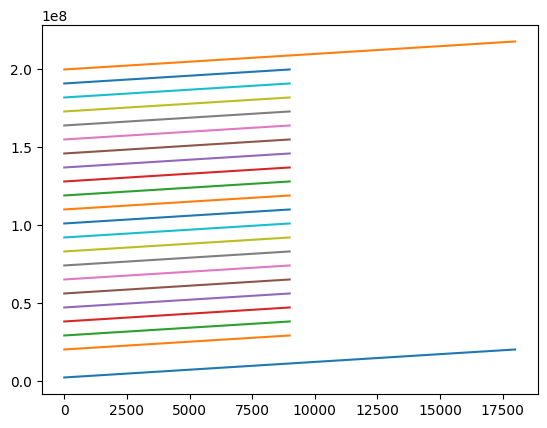

In [300]:
def clean_positions(positions):
    """
    Fonction de nettoyage des positions enregistrées au cours de l'expérience. Pour rappel, une valeur de -1, indique que le sujet n'a pas été détecté par le réseau de neurones.
    :param positions:
    :return:
    """
    y = np.where(positions == -1)[0]
    diff_y = np.diff(y)
    diff_y = np.vstack((np.arange(1, len(diff_y) + 1), diff_y)).T
    k = 0
    begin = 0
    for i, elt in diff_y:
        if elt != 1:
            positions[y[i - 1]] = positions[y[i - 1] + 1]
            positions[y[i]] = positions[y[i] - 1]
            if k != 0:
                end = y[i - 1]
                filler = np.full(shape=k, fill_value=positions[begin - 1])
                positions[begin:end] = filler
                k = 0
        else:
            if k == 0:
                begin = y[i - 1]
            k += 1
    remainder = np.where(positions == -1)[0]
    if len(remainder) != 0 and k != 0:
        pass

    return positions


def gather_positions_file(folder, n_blocks):
    """
    Retourne une liste avec les fichiers des positions enregistrées au cours de l'expérience ordonnés.
    :param folder: Dossier de sauvegarde de l'expérience.
    :param n_blocks: Nombre de blocks.
    :return: Une liste avec les noms de fichiers dans l'ordre chronologique.
    """
    # Pipeline : extraire tous les fichiers, les remettre dans l'ordre. Nettoyer, couper.
    # Extraire les fréquences du Mock.
    # Comparer la longueur, une fois les changements détectés. OK.
    pause_pattern = "positions_Pause_0[0-9]"
    playback_pattern = "positions_Playback_playback_0[0-9]"
    tracking_pattern = "positions_Playback_tracking_0[0-9]"
    warmup_pattern = "positions_Playback_warmup_0[0-9]"

    glob_files = glob(os.path.join(folder, "positions", "positions_*.bin"))
    types_pos_list = [list() for _ in range(4)]
    for file in glob_files:
        if re.search(pause_pattern, file):
            types_pos_list[0].append(file)
        elif re.search(warmup_pattern, file):
            types_pos_list[1].append(file)
        elif re.search(tracking_pattern, file):
            types_pos_list[2].append(file)
        elif re.search(playback_pattern, file):
            types_pos_list[3].append(file)

    out = ["" for _ in glob_files]
    types = ["" for _ in glob_files]
    nums = [0 for _ in glob_files]
    for file_name in types_pos_list[0]:
        match = re.search(r"positions_Pause_(\d+)", file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[0] = file_name
                types[0] = "pause"
                nums[0] = 0
            else:
                out[-1] = file_name
                types[-1] = "pause"
                nums[-1] = 1

    for file_name in types_pos_list[1]:
        match = re.search(r"positions_Playback_warmup_(\d+)", file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[1] = file_name
                types[1] = "warmup"
                nums[1] = 0
            else:
                out[-2] = file_name
                types[-2] = "warmdown"
                nums[-2] = 0
    idx = 2
    # n_blocks = len(types_pos_list[2])

    for i in range(n_blocks):
        file_name = types_pos_list[2][i]
        match = re.search(r"positions_Playback_tracking_(\d+)", file_name)
        if match:
            # Ici, extraction du numéro de bloc. Je place au bon endroit dans la liste.
            value = int(match.group(1))
            pos = idx + value * 2
            out[pos] = file_name
            types[pos] = "tracking"
            nums[pos] = value

        file_name = types_pos_list[3][i]
        match = re.search(r"positions_Playback_playback_(\d+)", file_name)
        if match:
            # Ici, extraction du numéro de bloc. Je place au bon endroit dans la liste.
            value = int(match.group(1))
            pos = idx + value * 2 + 1
            out[pos] = file_name
            types[pos] = "playback"
            nums[pos] = value
    return out, types, nums


def add_position_file(file_list, fn, val, what):
    assert (what in ["tracking", "playback"])
    idx = val * 2
    if what == "playback":
        idx += 1
    file_list.append(fn)


def load_positions_file(files):
    """
    Charge les fichiers .bin et les empile.
    :param files: 
    :return: 
    """
    positions = list()
    seps = list()
    for file in files:
        p = np.fromfile(file, dtype=np.int32)
        s = np.zeros_like(p)
        s[0] = 1
        positions.append(p)
        seps.append(s)
    return np.hstack(positions), np.hstack(seps)


def split(x, separators):
    """
    Sépare les différents blocs à nouveau.
    :param x: 
    :param separators: 
    :return: 
    """
    cut_idx = np.where(separators == 1)[0][1:]
    x = np.split(x, cut_idx)
    return x


def detect_frequency_switch(vec, mapping):
    """
    Fonction qui a pour objectif de détecter les changements de fréquences.
    :param mapping:
    :param vec:
    :return:
    """
    # Je convertis le vecteur de positions en fréquences.
    tone_vec = mapping.convert_to_frequency(vec)
    d = np.diff(tone_vec)
    # Je repère les moments où les fréquences changent.
    idx = np.where(d != 0)[0] + 1
    
    # Je retourne un array de fréquences.
    switch = tone_vec[idx]
    return switch, idx


def foo(folder):
    delay_frame = 0.007  # secondes
    delay_frame_samples = int(delay_frame * 30e3)
    mapping = Mapping(1920, 33, 2000., 7)
    # Charger le tt.npz
    sequence = gd.extract_data(folder)
    # Charger les positions
    files, types, nums = gather_positions_file(folder, sequence.get_n_iter())
    # hstack positions
    positions, separators = load_positions_file(files)
    # clean_positions
    positions = clean_positions(positions)
    # Couper selon les séparations.
    positions = split(positions, separators)
    
    # L'idée maintenant, c'est d'itérer sur l'objet séquence.
    # Alternance Tracking / Playback
    triggers = list()
    separators = list()
    for i, triplet in enumerate(zip(types, nums, positions)):
        t, num, pos = triplet
        if t == "pause":
            continue    
        
        if t == "playback":
            t = "mock"
        
        block = sequence.get_xp_number(t, num)
        switches, idx = detect_frequency_switch(pos, mapping)
        # idx : indice du changement de fréquence dans les positions.
        # À peu près tous les blocks ont plus de fréquences que ce que vont dire les positions.
        if len(block.tones) != len(switches):
            past_positions = positions[i-1]
            past_switches, _ = detect_frequency_switch(past_positions, mapping)
            last_tone = past_switches[-1]
            switches = np.hstack((np.array(last_tone), switches))
            idx = np.hstack((np.array(0, dtype=int), idx))
        
        # Récupérer les triggers.
        # sound_triggers = block.triggers
        p_triggers = np.zeros_like(pos)
        seps = np.zeros_like(pos)
        seps[0] = 1
        for j, trigger in enumerate(idx):
            p_triggers[trigger] = block.triggers[j]
        indices = np.where(p_triggers != 0)[0]
        for i0, i1 in zip(indices[:-1], indices[1:]):
            segment = p_triggers[i0:i1]
            t0, t1 = p_triggers[i0], p_triggers[i1]
            dt = int((t1 - t0) / len(segment))

            p_triggers[i0:i1] = np.full_like(segment, t0) + np.arange(len(segment), dtype=int) * dt
            # print(p_triggers[t0:t1])
        triggers.append(p_triggers)
        separators.append(seps)
    
    # Enlever les zéros contigus, récupérer les indices.
    triggers = np.hstack(triggers)
    separators = np.hstack(separators)
    indices = np.where(np.diff(triggers) < 0)[0]
    stop = np.where(np.diff(triggers) > 100000)[0] + 1
    
    if len(indices) > len(stop):
        process_last = True
        last_index = indices[-1]
        indices = indices[:-1]
    else:
        process_last = True
        
    plt.scatter(indices, triggers[indices], c="green", s=5)
    plt.scatter(stop, triggers[stop], c="r", s=5)
    # plt.plot(triggers[zeros_blocks])
    # plt.show()
    for i0, i1 in zip(indices, stop):
        segment = triggers[i0:i1]
        t0, t1 = triggers[i0], triggers[i1]
        dt = int((t1 - t0) / len(segment))
        triggers[i0:i1] = np.full_like(segment, t0) + np.arange(len(segment), dtype=int) * dt
    
    # Pour le dernier segment de zéros.
    if process_last:
        indice = np.where(triggers == 0)[0][0]
        t0 = triggers[indice-1]
        dt = int(np.diff(triggers[:indice]).mean())
        segment = triggers[indice:]
        triggers[indice:] = np.full_like(segment, t0) + np.arange(len(segment), dtype=int) * dt
    triggers -= delay_frame_samples
    plt.plot(triggers)
    plt.show()
    triggers = split(triggers, separators)
    
    for elt in triggers:
        plt.plot(elt)
    plt.show()
    
    
    # à partir de là, je peux créer un objet ttp.

folders, save_folder = get_good_sessions("MUROLS")
foo(folders[0])     

In [ ]:
def append_zero(i, length):
    """

    :param i:
    :param length:
    :return:
    """
    assert (length % 10 == 0), "Length must be a power of ten."
    if i > length:
        n = str(i)
    else:
        block_size = int(np.log10(length))
        targets = np.array([10 ** x for x in range(1, block_size)], dtype=int)
        idx = np.less(targets, i)
        n = (block_size - np.sum(idx)) * "0" + str(i)
    return n


def get_pattern_from_type(type_of):
    """

    :param type_of:
    :return:
    """
    if type_of == "playback":
        return "pb_"
    elif type_of == "tracking":
        return "tr_"
    elif type_of == "mock":
        return "mk_"
    elif type_of == "warmup":
        return "wp_"
    elif type_of == "warmdown":
        return "wd_"
    elif type_of == "PureTones":
        return "pt_"
    elif type_of == "silence":
        return "si_"
    else:
        return None


def get_type_from_pattern(pattern):
    """

    :param pattern:
    :return:
    """
    """
    Conversion en un type.
    :param pattern:
    :return:
    """
    if re.match("pb_[0-9]", pattern):
        return "playback"
    elif re.search("tr_[0-9]", pattern):
        return "tracking"
    elif re.search("mk_[0-9]", pattern):
        return "mock"
    elif re.search("wp_[0-9]", pattern):
        return "warmup"
    elif re.search("wd_[0-9]", pattern):
        return "warmdown"
    elif re.search("si_[0-9]", pattern):
        return "silence"
    elif re.search("pt_[0-9]", pattern):
        return "PureTones"
    else:
        return None




In [223]:
class TT(object):
    def __init__(self, tones, triggers):
        assert (len(tones) == len(triggers)), "Tones and Triggers have different length."
        self.length = len(tones)
        self.tones = tones
        self.triggers = triggers


class Pair(object):
    def __init__(self, tones, triggers, type_of, number=None, order=None):
        assert (len(tones) == len(triggers)), "Tones and Triggers have different length."
        self.tones = tones

        self.triggers = triggers
        self.tt = TT(tones, triggers)

        assert (type_of in ["playback", "tracking", "warmup", "warmdown", "mock", "PureTones", "silence"]), "Wrong type..."
        self.type = type_of

        if order is not None:
            self.order = order
        else:
            self.order = None

        if number is not None:
            self.number = number
            self.pattern = get_pattern_from_type(self.type) + str(self.number)
        else:
            self.number = None
            self.pattern = None

    def get_stacked(self):
        return np.vstack((self.tones, self.triggers))

    def get_tones(self):
        return self.tones

    def get_triggers(self):
        return self.triggers

    def get_pairs(self):
        return self.tt

    def get_pattern(self):
        return self.pattern

    def get_type(self):
        return self.type

    def get_begin_and_end_triggers(self):
        return self.triggers[0], self.triggers[-1]

307500

In [ ]:
class SequenceTT(object):
    """

    """
    def __init__(self, folder=None, n_iter=None):
        self._fn = "tt.npz"
        self.container = dict()
        self.keys = list()
        self.order = np.empty(0, dtype=int)
        self.numbers = np.empty(0, dtype=int)
        self.total_iter = 0
        self.allowed = ["playback", "tracking", "warmup", "warmdown", "mock"]
        if n_iter is not None:
            self.total_iter = n_iter
        self.recording_length = 0

        if folder is not None:
            self._load(folder)

    def _load(self, folder):
        d = np.load(os.path.join(folder, self._fn), allow_pickle=True)
        self.recording_length = d["recording_length"][0]
        self.order = d["order"]
        self.total_iter = d["n_iter"][0]
        self.keys = [key.decode() for key in d["keys"]]
        self.numbers = d["numbers"]
        for i, key in enumerate(self.keys):
            tones, triggers = d[key][0], d[key][1]
            self.container[key] = Pair(tones, triggers, type_of=get_type_from_pattern(key), order=self.order[i])

    def get_number_iteration(self):
        return self.total_iter

    def save(self, folder,):
        """

        """
        fn = os.path.join(folder, self._fn)
        kwargs = dict()
        kwargs["order"] = np.array(self.order)
        kwargs["n_iter"] = np.array([self.total_iter])
        kwargs["recording_length"] = np.array([self.recording_length])
        kwargs["keys"] = self._build_chararray()
        kwargs["numbers"] = self.numbers
        for key in self.container.keys():
            kwargs[key] = self.container[key].get_stacked()
        # kwargs = {key: self.container[key].get_stacked() for key in self.container.keys()}
        np.savez(fn, **kwargs)

    def _build_chararray(self):
        n = np.array(self.keys).shape
        ch = np.chararray(n, itemsize=5)
        for i, elt in enumerate(self.keys):
            ch[i] = elt
        return ch

    def get_container(self):
        return self.container

    def get_xp_type_all(self, type_of, as_tt=True):
        """
        On va chercher toutes les expériences d'un certain type.
        """
        assert (type_of in self.allowed), "Wrong type..."
        pattern = get_pattern_from_type(type_of)
        if as_tt:
            out = SequenceTT()
            for i, k in enumerate(self.keys):
                if re.search(pattern, k):
                    tmp = self.container[k]
                    p = Pair(tmp.tones, tmp.triggers, type_of, number=self.numbers[i], order=self.order[i])
                    out.add(p)
            out.set_n_iter(self.total_iter)
        else:
            out = dict()
            for k in self.container.keys():
                if re.search(pattern, k):
                    out[k] = self.container[k]
        return out

    def merge(self, type_of):
        """
        On lui donne un type d'expériences. Renvoie une paire. Mets tous les triggers et les tones dedans.
        """
        d_out = self.get_xp_type_all(type_of, as_tt=False)
        l_number = list()
        # mettre dans l'ordre
        for k in d_out.keys():
            l_number.append(k)
        l_number.sort()
        tones = list()
        triggers = list()
        for k in l_number:
            p = d_out[k]
            type_of = p.get_type()
            tones.append(p.get_tones())
            triggers.append(p.get_triggers())
        triggers = np.hstack(triggers)
        tones = np.hstack(tones)
        return Pair(tones, triggers, type_of)

    def get_xp_number(self, type_of, n):
        """
        On demande une expérience d'un type donné, à un moment donné.
        """
        assert (type_of in self.allowed), "Wrong type..."
        if type_of not in ["warmup", "warmdown"]:
            assert (n < self.total_iter), "Unavailable."
        pattern = get_pattern_from_type(type_of) + str(n)
        assert (pattern in self.keys), "Not existing"
        return self.container[pattern]

    def get_all_number(self, n):
        """
        On va chercher le triplet Playback, Tracking, Mock.
        """
        assert (n < self.total_iter), "Unavailable."
        pattern = str(n)
        d_out = dict()
        for k in self.container.keys():
            if re.search(pattern, k):
                d_out[k] = self.container[k]

        return d_out

    def get_from_type_and_number(self, type_of, n):
        assert (type_of in self.allowed), "Wrong type..."
        assert (n < self.total_iter), "Unavailable."
        pattern = get_pattern_from_type(type_of) + str(n)
        for k in self.container.keys():
            if re.search(pattern, k):
                return self.container[k]

    def get_triggers(self):
        list_triggers = list()
        for elt in self.keys:
            list_triggers.append(self.container[elt].get_triggers())
        return np.hstack(list_triggers)

    def get_all_triggers_for_type(self, type_of):
        p = self.merge(type_of)  # sort un objet Pair.
        return p.get_triggers()

    def add(self, pairs):
        pattern = pairs.get_pattern()
        order = pairs.order
        number = pairs.number
        assert (pattern not in self.keys), "Already in DataStructure."
        assert (order not in self.order), "Already in DataStructure."
        self.numbers = np.hstack((self.numbers, number))
        self.order = np.hstack((self.order, order))
        self.keys.append(pattern)
        self.container[pattern] = pairs

    def set_recording_length(self, length):
        self.recording_length = length

    def get_recording_length(self):
        return self.recording_length

    def set_n_iter(self, n_iter):
        self.total_iter = n_iter

    def get_n_iter(self):
        return self.total_iter

In [ ]:
class PT(object):
    def __init__(self, positions, triggers):
        assert (len(positions) == len(triggers)), "Tones and Triggers have different length."
        self.length = len(positions)
        self.tones = positions
        self.triggers = triggers
        

class PositionPair(object):
    def __init__(self, values, triggers, type_of, number=None, order=None):
        assert (len(values) == len(triggers)), "Tones and Triggers have different length."
        self.values = values

        self.triggers = triggers
        self.tt = PT(values, triggers)

        assert (type_of in ["playback", "tracking", "warmup", "warmdown", "mock", "PureTones", "silence"]), "Wrong type..."
        self.type = type_of

        if order is not None:
            self.order = order
        else:
            self.order = None

        if number is not None:
            self.number = number
            self.pattern = get_pattern_from_type(self.type) + str(self.number)
        else:
            self.number = None
            self.pattern = None

    def get_stacked(self):
        return np.vstack((self.values, self.triggers))

    def get_values(self):
        return self.values

    def get_triggers(self):
        return self.triggers

    def get_pairs(self):
        return self.tt

    def get_pattern(self):
        return self.pattern

    def get_type(self):
        return self.type

    def get_begin_and_end_triggers(self):
        return self.triggers[0], self.triggers[-1]
    
    
class SequencePT(object):
    """
    
    """
    def __init__(self, folder=None, n_iter=None):
        self._fn = "pt.npz"
        self.container = dict()
        self.keys = list()
        self.order = np.empty(0, dtype=int)
        self.numbers = np.empty(0, dtype=int)
        self.total_iter = 0
        self.allowed = ["playback", "tracking", "warmup", "warmdown"]
        if n_iter is not None:
            self.total_iter = n_iter
        self.recording_length = 0

        if folder is not None:
            self._load(folder)
            
    def add(self, pairs):
        pattern = pairs.get_pattern()
        order = pairs.order
        number = pairs.number
        assert (pattern not in self.keys), "Already in DataStructure."
        assert (order not in self.order), "Already in DataStructure."
        self.numbers = np.hstack((self.numbers, number))
        self.order = np.hstack((self.order, order))
        self.keys.append(pattern)
        self.container[pattern] = pairs
            
    def _load(self, folder):
        d = np.load(os.path.join(folder, self._fn), allow_pickle=True)
        self.recording_length = d["recording_length"][0]
        self.order = d["order"]
        self.total_iter = d["n_iter"][0]
        self.keys = [key.decode() for key in d["keys"]]
        self.numbers = d["numbers"]
        for i, key in enumerate(self.keys):
            tones, triggers = d[key][0], d[key][1]
            self.container[key] = Pair(tones, triggers, type_of=get_type_from_pattern(key), order=self.order[i])
            
    def get_number_iteration(self):
        return self.total_iter
    
    def save(self, folder):
        """

        """
        
        fn = os.path.join(folder, self._fn)
        kwargs = dict()
        kwargs["order"] = np.array(self.order)
        kwargs["n_iter"] = np.array([self.total_iter])
        kwargs["recording_length"] = np.array([self.recording_length])
        kwargs["keys"] = self._build_chararray()
        kwargs["numbers"] = self.numbers
        for key in self.container.keys():
            kwargs[key] = self.container[key].get_stacked()
        np.savez(fn, **kwargs)
        
    def _build_chararray(self):
        n = np.array(self.keys).shape
        ch = np.chararray(n, itemsize=5)
        for i, elt in enumerate(self.keys):
            ch[i] = elt
        return ch
    
    def get_xp_number(self, type_of, n):
        """
        On demande une expérience d'un type donné, à un moment donné.
        """
        assert (type_of in self.allowed), "Wrong type..."
        if type_of not in ["warmup", "warmdown"]:
            assert (n < self.total_iter), "Unavailable."
        pattern = get_pattern_from_type(type_of) + str(n)
        assert (pattern in self.keys), "Not existing"
        return self.container[pattern]

In [ ]:
class TonePair(object):
    def __init__(self, values, triggers, type_of, number=None, order=None):
        assert (len(values) == len(triggers)), "Tones and Triggers have different length."
        self.values = values

        self.triggers = triggers
        self.tt = TT(values, triggers)

        assert (type_of in ["playback", "tracking", "warmup", "warmdown", "mock", "PureTones", "silence"]), "Wrong type..."
        self.type = type_of

        if order is not None:
            self.order = order
        else:
            self.order = None

        if number is not None:
            self.number = number
            self.pattern = get_pattern_from_type(self.type) + str(self.number)
        else:
            self.number = None
            self.pattern = None

    def get_stacked(self):
        return np.vstack((self.values, self.triggers))

    def get_values(self):
        return self.values

    def get_triggers(self):
        return self.triggers

    def get_pairs(self):
        return self.tt

    def get_pattern(self):
        return self.pattern

    def get_type(self):
        return self.type

    def get_begin_and_end_triggers(self):
        return self.triggers[0], self.triggers[-1]